# Autoregressive Integrated Moving Average (ARIMA)

The <a href="https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average">ARIMA</a> model is a generalisation of an ARMA model that can be applied to non-stationary time series.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
matplotlib.rcParams['figure.figsize'] = (16, 9)
pd.options.display.max_columns = 999

## Load Dataset

In [3]:
df = pd.read_csv('../datasets/hourly-weather-wind_direction.csv', parse_dates=[0], index_col='DateTime')
print(df.shape)
df.head()

(5000, 36)


,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9,ts10,ts11,ts12,ts13,ts14,ts15,ts16,ts17,ts18,ts19,ts20,ts21,ts22,ts23,ts24,ts25,ts26,ts27,ts28,ts29,ts30,ts31,ts32,ts33,ts34,ts35,ts36
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-25 01:00:00,180.0,190.0,150.0,190.0,260.0,310.0,60.0,170.0,320.0,140.0,230.0,210.0,170.0,130.0,30.0,170.0,10.0,140.0,220.0,164.0,30.0,80.0,191.0,80.0,250.0,20.0,230.0,238.0,350.0,220.0,268.0,0.0,342.0,7.0,7.0,0.0
2017-03-25 02:00:00,180.0,210.0,150.0,200.0,270.0,261.0,140.0,160.0,310.0,160.0,220.0,200.0,180.0,120.0,30.0,150.0,30.0,140.0,210.0,140.0,20.0,110.0,173.0,70.0,240.0,350.0,208.0,213.0,340.0,230.0,249.0,0.0,360.0,10.0,10.0,0.0
2017-03-25 03:00:00,250.0,210.0,160.0,190.0,260.0,261.0,150.0,190.0,310.0,87.0,310.0,250.0,180.0,130.0,50.0,150.0,360.0,140.0,210.0,140.0,360.0,110.0,173.0,80.0,230.0,50.0,208.0,213.0,320.0,230.0,249.0,0.0,343.0,10.0,10.0,0.0
2017-03-25 04:00:00,180.0,0.0,160.0,180.0,220.0,290.0,200.0,259.0,310.0,87.0,310.0,290.0,230.0,70.0,50.0,140.0,360.0,140.0,210.0,140.0,30.0,120.0,173.0,50.0,220.0,60.0,208.0,240.0,310.0,230.0,249.0,0.0,10.0,0.0,0.0,0.0
2017-03-25 05:00:00,190.0,220.0,160.0,180.0,270.0,300.0,240.0,256.0,360.0,220.0,320.0,290.0,200.0,50.0,70.0,120.0,360.0,130.0,180.0,160.0,30.0,90.0,180.0,90.0,230.0,20.0,217.0,208.0,240.0,230.0,250.0,0.0,340.0,13.0,13.0,0.0


## Define Parameters

Make predictions for 24-hour period using a training period of four weeks.

In [4]:
dataset_name = 'Hourly Weather Wind Direction'
dataset_abbr = 'HWD'
model_name = 'ARIMA'
context_length = 24*7*4 # Four weeks
prediction_length = 24

## Define Error Metric

The seasonal variant of the mean absolute scaled error (MASE) will be used to evaluate the forecasts.

In [5]:
def calc_sMASE(training_series, testing_series, prediction_series, seasonality=prediction_length):
    a = training_series.iloc[seasonality:].values
    b = training_series.iloc[:-seasonality].values
    d = np.sum(np.abs(a-b)) / len(a)
    errors = np.abs(testing_series - prediction_series)
    return np.mean(errors) / d

## Example ARIMA Model

Exploration of how ARIMA models work using a single example time series.

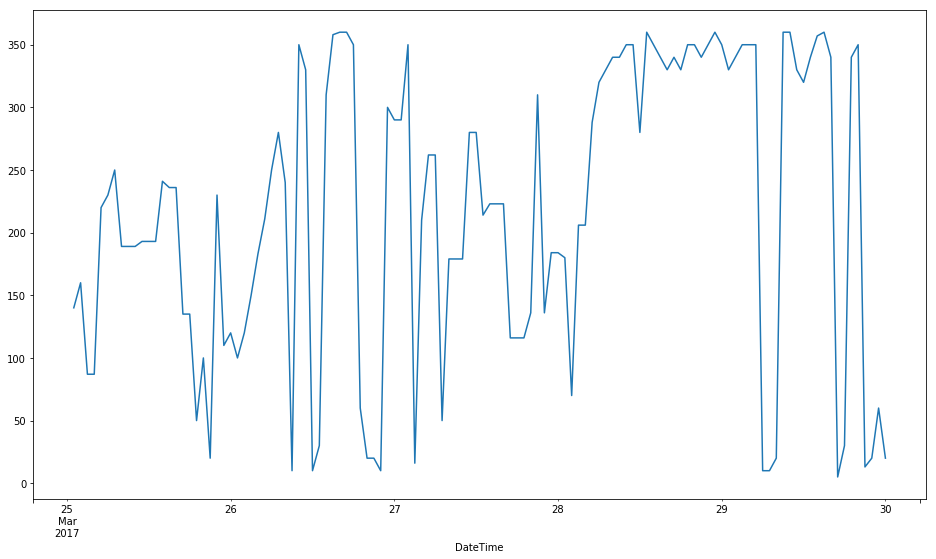

In [6]:
ts_ex = 'ts10'
df_ex = df.loc[:, ts_ex]

# Plot data from first five days
df_ex.iloc[:24*5].plot();

### Time Series Decomposition

Decompose the example time series into trend, seasonal, and residual components.

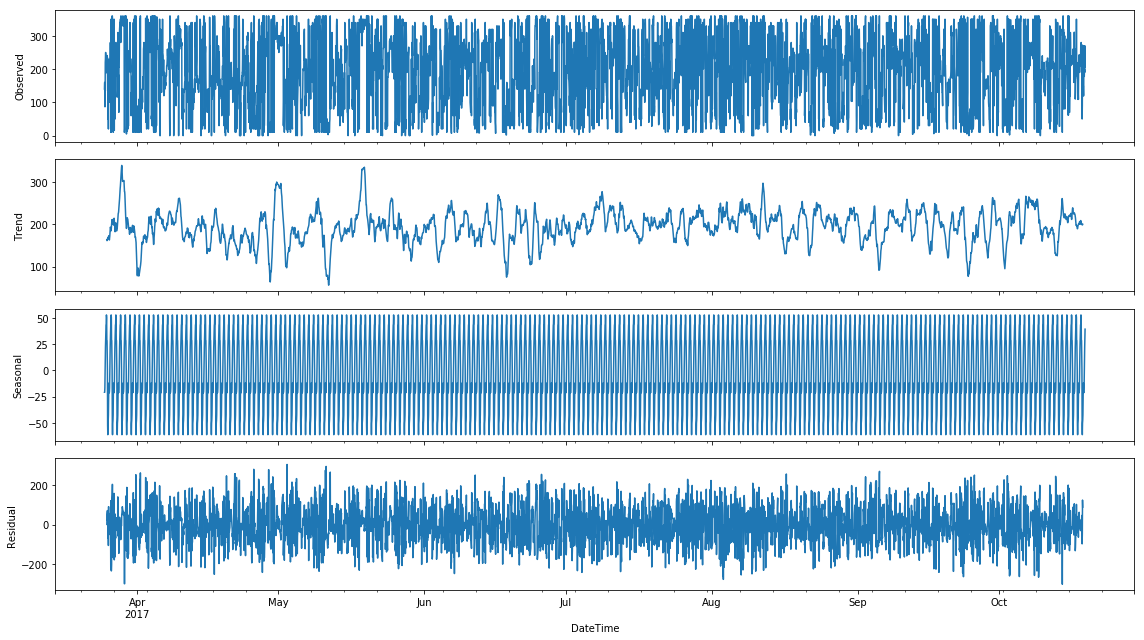

In [7]:
fig = seasonal_decompose(df_ex, model='additive').plot()

There doesn't appear to be a consistent trend. A Dicky-Fuller test can be used to confirm the stationarity.

In [8]:
dftest = adfuller(df_ex, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -1.187517e+01
p-value                        6.366034e-22
#Lags Used                     3.200000e+01
Number of Observations Used    4.967000e+03
Critical Value (1%)           -3.431667e+00
Critical Value (5%)           -2.862122e+00
Critical Value (10%)          -2.567080e+00
dtype: float64

The very low p-value confirms that the data is stationary. There is clearly daily seasonality, but this won't be considered for the ARIMA model (see the SARIMA or ARIMAX notebooks for models that account for this). As there is no trend and seasonality is not being considered, no differencing will be applied to the time series.

### Plot ACF and PACF

The <a href="https://en.wikipedia.org/wiki/Autocorrelation">Autocorrelation Function</a> (ACF) is the correlation of a signal with a delayed copy of itself as a function of delay.

The <a href="https://en.wikipedia.org/wiki/Partial_autocorrelation_function">Partial Autocorrelation Function</a> (PACF) is the partial correlation of a signal with a delayed copy of itself, controlling for the values of the time series at all shorter delays, as a function of delay.

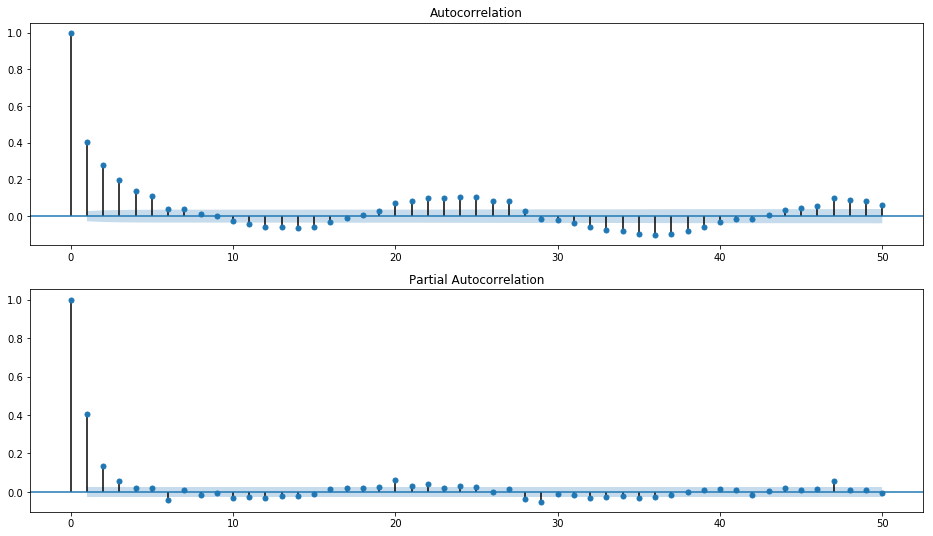

In [9]:
fig, ax = plt.subplots(2)
ax[0] = sm.graphics.tsa.plot_acf(df_ex, lags=50, ax=ax[0])
ax[1] = sm.graphics.tsa.plot_pacf(df_ex, lags=50, ax=ax[1])

There is clearly daily seasonality.

### Build Model

Grid search will be implemented to identify optimal parameters for the ARIMA(p, d, q) model, using the following possible values:

In [10]:
from itertools import product

ps = range(0, 5) # Up to 4 AR terms
ds = range(0, 2) # Either no or first differencing
qs = range(0, 5) # Up to 4 MA terms

params = product(ps, ds, qs)
params_list = list(params)
print("Number of parameter combinations for grid search: {}".format(len(params_list)))

Number of parameter combinations for grid search: 50


In [11]:
def optimiseARIMA(time_series, params_list=params_list, test_length=prediction_length, train_length=context_length):
    ts = time_series.iloc[-(test_length+train_length):]
    ts_train = ts.iloc[:-test_length]
    ts_test = ts.iloc[-test_length:]
    
    # Select the best model using a holdout validation period
    val_length = test_length
    ts_train_val = ts.iloc[:-(test_length+val_length)]
    ts_val = ts.iloc[-(test_length+val_length):-test_length]
    
    results = []
    
    for params in params_list:
        p = params[0]
        d = params[1]
        q = params[2]
        
        # try/except loop in case model fails to converge for given parameters
        try:
            arima = sm.tsa.ARIMA(ts_train_val, order=(p, d, q)).fit()
        except:
            continue
        
        # Make predictions for validation holdout set and update best model if necessary
        val_pred = arima.predict(start=ts_val.index[0], end=ts_val.index[-1], dynamic=True)
        sMASE = calc_sMASE(ts_train, ts_val, val_pred)

        results.append([params, sMASE])
            
    df_results = pd.DataFrame(results)
    df_results.columns = ['parameters', 'sMASE']
    df_results = df_results.sort_values(by='sMASE', ascending=True).reset_index(drop=True)
    
    # Retrain model with best parameters using all training data and generate test forecast
    # Use loop to fall back to next best model in case training fails using full dataset
    trained = False
    model_rank = 1
    while not trained:
        train_params = df_results.iloc[model_rank-1, 0]
        try:
            arima = sm.tsa.ARIMA(ts_train, order=train_params).fit()
            trained = True
        except:
            model_rank += 1
        
    summary = arima.summary()
    
    # Start index must be greater than q. Fill missing initial entries with zeroes
    fcst = arima.predict(start=ts_train.index[train_params[2]+1], end=ts_test.index[-1])
    fcst = np.concatenate([np.array([0 for i in range(train_params[2]+1)]), fcst])
    fcst = pd.DataFrame(data=fcst, index=ts.index, columns=['pred%s' % ts.name[2:]])
    
    return fcst, train_params, summary

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
%%time
fcst, train_params, summary = optimiseARIMA(df_ex)
df_ex = pd.concat([df_ex, fcst], axis=1)
print("Best model: ARIMA{}".format(train_params))
print(summary)

Best model: ARIMA(0, 0, 0)
                              ARMA Model Results                              
Dep. Variable:                   ts10   No. Observations:                  672
Model:                     ARMA(0, 0)   Log Likelihood               -4103.919
Method:                           css   S.D. of innovations            108.645
Date:                Sat, 13 Oct 2018   AIC                           8211.839
Time:                        18:27:42   BIC                           8220.859
Sample:                    09-20-2017   HQIC                          8215.332
                         - 10-18-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        197.9851      4.191     47.240      0.000     189.771     206.199
Wall time: 28 s


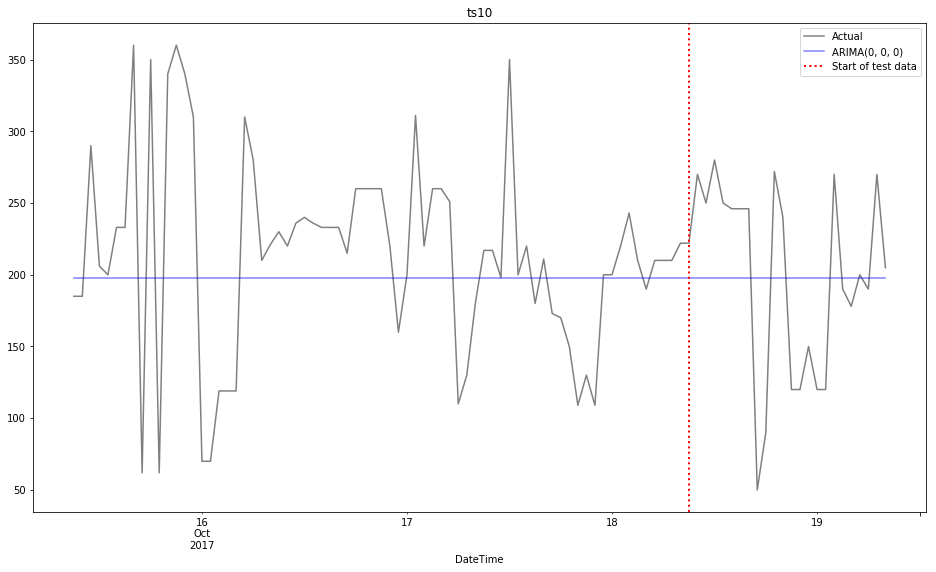

In [14]:
# Example forecast
fcst0 = df_ex.copy()
fcst0['pred%s' % ts_ex[2:]][fcst0['pred%s' % ts_ex[2:]] < 0] = 0

fcst0.iloc[-4*prediction_length:, 0].plot(label='Actual', c='k', alpha=0.5)
fcst0.iloc[-4*prediction_length:, 1].plot(label='ARIMA%s' % str(train_params), c='b', alpha=0.5)
plt.axvline(x=fcst0.index[-prediction_length], linestyle=':', linewidth=2, color='r', label='Start of test data')
plt.legend()
plt.title(ts_ex);

## Evaluating ARIMA

To evaluate ARIMA, forecasts will be generated for each time series using the grid search methodology shown above (with subsequent zeroing of the negative values). sMASE will be calculated for each individual time series, and the mean of all these scores will be used as the overall accuracy metric for ARIMA on this dataset.

In [15]:
parameters = []
results = df.iloc[-(prediction_length+context_length):].copy()

tic = time()
for i, col in enumerate(df.columns):
    if i % 10 == 0:
        toc = time()
        print("Running predictions for {}. Cumulative time: {:.1f} minutes.".format(col, (toc-tic)/60))
        
    # Prepare DataFrame for selected column
    dft = df.loc[:, col]
    
    # Find best model
    fcst, train_params, summary = optimiseARIMA(dft)
    # Add predictions to results DataFrame
    results['pred%s' % col[2:]] = fcst.values
    # Store model parameteres for reference
    parameters.append(train_params)

toc = time()
print("Finished! Total run time: {:.1f} minutes.".format((toc-tic)/60))

Running predictions for ts1. Cumulative time: 0.0 minutes.
Running predictions for ts11. Cumulative time: 4.0 minutes.
Running predictions for ts21. Cumulative time: 6.3 minutes.
Running predictions for ts31. Cumulative time: 9.0 minutes.
Finished! Total run time: 11.4 minutes.


In [16]:
results0 = results.copy()
results0[results0 < 0] = 0
results0.head()

,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9,ts10,ts11,ts12,ts13,ts14,ts15,ts16,ts17,ts18,ts19,ts20,ts21,ts22,ts23,ts24,ts25,ts26,ts27,ts28,ts29,ts30,ts31,ts32,ts33,ts34,ts35,ts36,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,pred10,pred11,pred12,pred13,pred14,pred15,pred16,pred17,pred18,pred19,pred20,pred21,pred22,pred23,pred24,pred25,pred26,pred27,pred28,pred29,pred30,pred31,pred32,pred33,pred34,pred35,pred36
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-09-20 09:00:00,80.0,110.0,309.0,90.0,330.0,150.0,220.0,120.0,230.0,170.0,150.0,180.0,190.0,190.0,150.0,180.0,150.0,178.0,173.0,332.0,90.0,198.0,230.0,186.0,117.0,50.0,360.0,0.0,30.0,30.0,292.0,280.0,343.0,280.0,280.0,280.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2017-09-20 10:00:00,160.0,120.0,340.0,177.0,310.0,140.0,10.0,100.0,230.0,160.0,150.0,170.0,170.0,190.0,140.0,160.0,111.0,178.0,173.0,332.0,103.0,198.0,230.0,186.0,117.0,60.0,350.0,0.0,20.0,20.0,292.0,290.0,350.0,270.0,270.0,290.0,170.60119,0.000000,248.730784,0.000000,0.000000,0.0,213.271806,0.000000,0.000000,197.98512,131.088366,0.000000,0.000000,0.000000,0.000000,179.633105,0.000000,0.000000,0.000000,284.124623,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.262665,76.138659,0.000000,0.0,0.0,270.514881,0.0,0.0,0.0
2017-09-20 11:00:00,180.0,0.0,340.0,37.0,54.0,140.0,180.0,110.0,210.0,150.0,190.0,190.0,190.0,190.0,160.0,160.0,133.0,171.0,163.0,300.0,137.0,233.0,220.0,177.0,30.0,60.0,340.0,0.0,10.0,20.0,311.0,280.0,320.0,260.0,260.0,280.0,170.60119,0.000000,269.448980,0.000000,0.000000,0.0,138.062561,0.000000,0.000000,197.98512,132.809744,0.000000,104.874114,0.000000,0.000000,169.983735,0.000000,0.000000,0.000000,302.209049,111.167223,0.0,0.000000,156.572194,0.000000,80.020000,307.777166,0.368252,58.025623,85.095808,0.0,0.0,270.514881,0.0,0.0,0.0
2017-09-20 12:00:00,80.0,120.0,350.0,37.0,54.0,170.0,209.0,130.0,217.0,160.0,150.0,170.0,160.0,180.0,230.0,150.0,0.0,171.0,163.0,347.0,137.0,233.0,220.0,177.0,122.0,20.0,330.0,0.0,30.0,20.0,311.0,290.0,10.0,260.0,260.0,290.0,170.60119,0.000000,279.296623,0.000000,120.671977,0.0,167.414579,150.308326,0.000000,197.98512,149.488191,178.469979,112.820409,0.000000,181.258395,166.706200,0.000000,0.000000,169.744284,287.781082,124.338100,0.0,4.260163,156.095654,0.000000,78.801637,309.609641,0.483160,45.011758,74.002191,0.0,0.0,270.514881,0.0,0.0,0.0
2017-09-20 13:00:00,30.0,140.0,350.0,37.0,54.0,120.0,310.0,90.0,130.0,130.0,160.0,170.0,160.0,240.0,200.0,170.0,130.0,171.0,170.0,347.0,137.0,233.0,190.0,177.0,110.0,60.0,350.0,10.0,30.0,20.0,311.0,290.0,310.0,270.0,270.0,290.0,170.60119,148.799353,285.030644,125.100781,71.977667,0.0,204.149138,159.928847,186.038581,197.98512,135.249397,171.839398,109.319803,184.044109,214.684410,160.181588,76.599477,164.015895,167.159413,296.884491,131.385864,0.0,2.840793,155.795734,136.780189,65.691181,307.391133,0.483160,49.524737,68.140409,0.0,0.0,270.514881,0.0,0.0,0.0


In [17]:
sMASEs = []
for i, col in enumerate(df.columns):
    sMASEs.append(calc_sMASE(results0[col].iloc[-(context_length + prediction_length):-prediction_length],
                             results0[col].iloc[-prediction_length:],
                             results0['pred%s' % str(i+1)].iloc[-prediction_length:]))

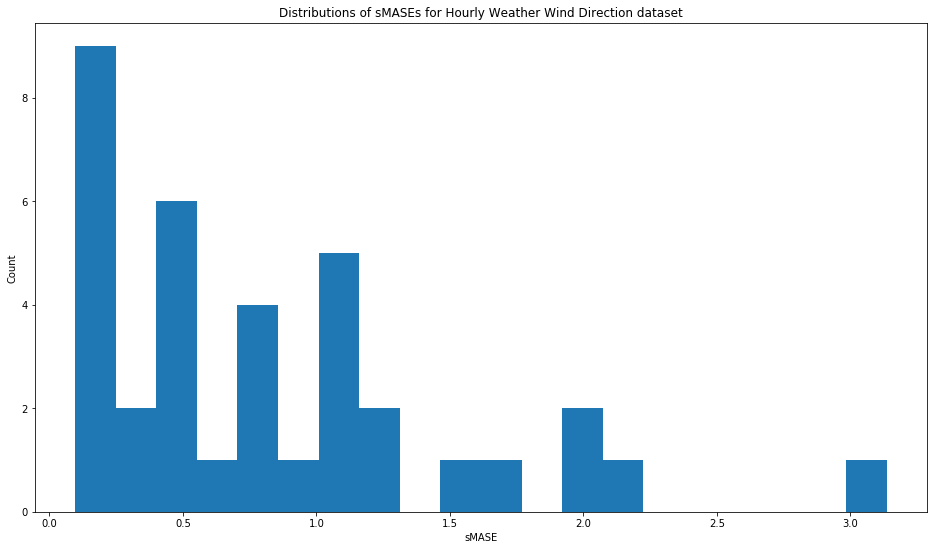

In [18]:
fig, ax = plt.subplots()
ax.hist(sMASEs, bins=20)
ax.set_title('Distributions of sMASEs for {} dataset'.format(dataset_name))
ax.set_xlabel('sMASE')
ax.set_ylabel('Count');

In [19]:
sMASE = np.mean(sMASEs)
print("Overall sMASE: {:.4f}".format(sMASE))

Overall sMASE: 0.8387


Show some example forecasts.

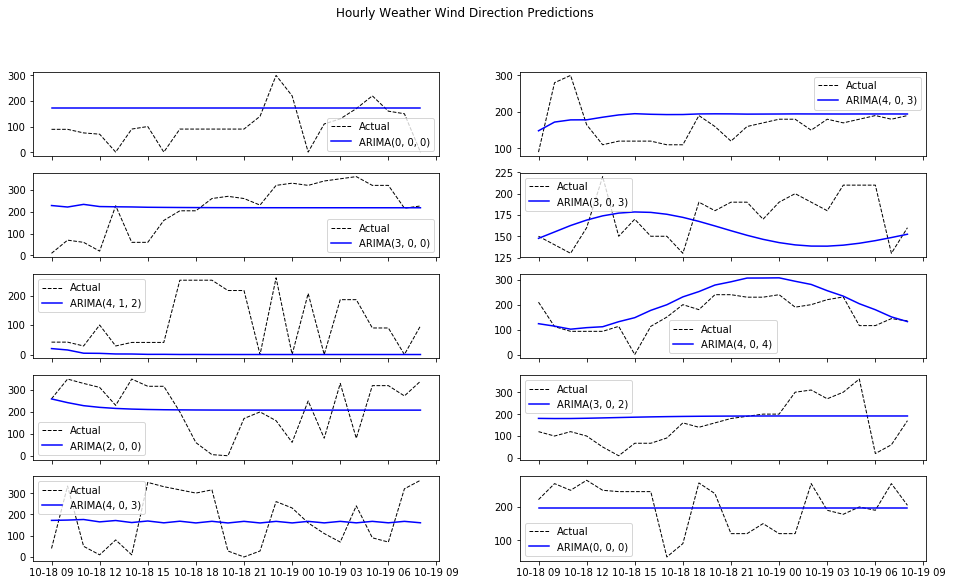

In [20]:
fig, ax = plt.subplots(5, 2, sharex=True)
ax = ax.ravel()

for col in range(1, 11):
    ax[col-1].plot(results0.index[-prediction_length:], results0['ts%s' % col].iloc[-prediction_length:],
                   label='Actual', c='k', linestyle='--', linewidth=1)
    ax[col-1].plot(results0.index[-prediction_length:], results0['pred%s' % col].iloc[-prediction_length:],
                   label='ARIMA%s' % str(parameters[col-1]), c='b')
    ax[col-1].legend()
fig.suptitle('{} Predictions'.format(dataset_name));

Store the predictions and accuracy score for the ARIMA models.

In [21]:
import pickle
    
with open('{}-sMASE.pkl'.format(dataset_abbr), 'wb') as f:
    pickle.dump(sMASE, f)
    
with open('../_results/{}/{}-results.pkl'.format(model_name, dataset_abbr), 'wb') as f:
    pickle.dump(results.iloc[-prediction_length:], f)